------

In [ ]:
#! OneDrive remote volume for data ~40GB
# rclone mount onedrive: ~/onedrive --vfs-cache-mode writes

-----

In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
matplotlib.rcParams['figure.dpi'] = 360
matplotlib.rcParams['text.usetex'] = True
rc("animation", html = "jshtml")
# plt.style.use('dark_background')

from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp

import os
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']

In [2]:
import os
import sys
import subprocess

import numpy as np

from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel

from desimodel.footprint import radec2pix      # For getting healpix values #! install one by one
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks -
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3

from astropy.io import fits
from astropy.table import Table as t

plt.style.use('desi.mplstyle')

## Quality Assurance

### Data

In [3]:
with fits.open('/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative/10256/20211110/coadd-6-10256-thru20211110.fits') as hdu:
    table = t(hdu[1].data)

table[:5]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int32,float64,int32,int16,str8,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32
39627598921205758,6,523,6523,3000,0,58.06105532781466,-7.844730381328177,0.0,0.0,2015.5,5400.0,65537,1,TGT,-273.1197,293.17685,3200,0.8282908119699367,1,9010,0581m077,286068,2046,DEV,0.10329081,0.16889594,0.8941181,5.0928288,23.090591,17.384312,1304.1022,579.9537,115.244415,2.4127722,0.62262315,0.07052774,0.37336674,2.1266687,0.07093131,0.37410456,2.127905,0,4.0,0.78224266,0.1490181,-0.09411515,0,,0.0,0.0,0.0,0.0,S,3200,2,65537,0,0,0,58.06105532781466,-7.844730381328177,10256,1,1026.2406,1,1,0.002,0.002,0.004,0.004,58.061063701142395,0.0,-7.844745780540812,0.0,0.7535512,-273.15,293.209
39627592927548911,6,474,6474,3001,0,57.9601110121448,-7.89223173938429,0.0,0.0,2015.5,5400.0,655394,1,TGT,-246.4184,279.77756,3100,0.9263659842739236,1,9010,0578m080,284639,5615,EXP,0.09190713,0.44930714,0.55495876,1.3918242,1.4065925,2.9532928,856.42194,370.58426,103.086266,3.2223678,0.714826,0.18568055,0.22934209,0.5751849,0.18568055,0.22934209,0.5751849,0,1.0,0.90412915,-0.05921823,-0.34269872,0,,0.0,0.0,0.0,0.0,S,3100,2,655394,0,0,0,57.9601110121448,-7.89223173938429,10256,1,1026.2406,1,1,0.0,0.0,0.003,0.003,57.96011146941822,0.0,-7.892243191472648,0.0,0.75187033,-246.453,279.815
-102566510,6,510,6510,3002,2,58.04899607076997,-7.8872989403559846,0.0,0.0,0.0,5400.0,0,4,SKY,-269.48013,281.82056,0,0.0,0,0,,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,0,0,0,0,0,0,58.04899607076997,-7.8872989403559846,10256,1,1026.2406,1,1,0.011,0.011,-0.016,0.016,58.049035801379844,0.0,-7.887239500996872,0.0,0.79421014,-269.525,281.877
39627592919159653,6,225,6225,3003,0,57.42273981571801,-7.948092196232115,0.0,0.0,2015.5,5400.0,655458,1,TGT,-110.59534,262.343,3200,0.41043580565191606,1,9010,0573m080,284637,4965,REX,0.08614483,0.287727,0.35610306,0.6101899,1.0853492,0.95953184,1216.2855,564.4347,188.81157,3.4217691,0.8034978,0.18372515,0.227386,0.3896306,0.18372661,0.22739355,0.3896606,0,1.0,0.3171792,0.0,0.0,0,,0.0,0.0,0.0,0.0,S,3200,2,655458,0,0,0,57.42273981571801,-7.948092196232115,10256,1,1026.2406,1,1,-0.005,0.005,0.002,0.002,57.42271974359218,0.0,-7.948099751372594,0.0,0.78175586,-110.606,262.366
39627592931737923,6,493,6493,3004,0,57.99613938643519,-7.885523616965909,-0.50909835,0.019917257,2015.5,5400.0,4611686018427650052,1,TGT,-255.79106,281.8342,3400,0.3276324389131303,63,9010,0581m080,284640,323,PSF,0.09598771,15.531595,19.49376,30.028728,42.37227,78.32307,561.3778,295.4461,177.27841,2.4441175,0.5516597,12.095261,15.180803,23.384932,12.095264,15.18081,23.384941,0,0

In [4]:
list(table.columns)

['TARGETID',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'COADD_FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'RELEASE',
 'BRICKNAME',
 'BRICKID',
 'BRICK_OBJID',
 'MORPHTYPE',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'PHOTSYS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET',
 'SCND_TARGET',
 'PLATE_RA',
 'PLATE_DEC',
 'TILEID',
 'COADD_NUMEXP',
 'COADD_EXPTIME',
 'COADD_NUMNIGHT',
 'COADD_NUMTILE',
 '

### Tiles

In [3]:
path = '/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative'

tile = [f for f in os.listdir('/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative/10256/20211110/') if f.startswith('coadd-')]
tile

['coadd-0-10256-thru20211110.fits',
 'coadd-1-10256-thru20211110.fits',
 'coadd-2-10256-thru20211110.fits',
 'coadd-3-10256-thru20211110.fits',
 'coadd-4-10256-thru20211110.fits',
 'coadd-5-10256-thru20211110.fits',
 'coadd-6-10256-thru20211110.fits',
 'coadd-7-10256-thru20211110.fits',
 'coadd-8-10256-thru20211110.fits',
 'coadd-9-10256-thru20211110.fits']

In [4]:
# plt.style.use('default')
palette = sns.color_palette("mako", 10)
palette

[(0.13701138, 0.08259683, 0.15060265),
 (0.20976258, 0.14925954, 0.29687795),
 (0.25007383, 0.22365053, 0.45519562),
 (0.23807973, 0.32226344, 0.58941872),
 (0.21112526, 0.42903064, 0.6266318),
 (0.20418396, 0.53013715, 0.64946117),
 (0.20968223, 0.63088252, 0.6701105),
 (0.26604085, 0.73564353, 0.67914062),
 (0.4285828, 0.82635051, 0.6780564),
 (0.68051833, 0.88963189, 0.75150483)]

In [5]:
tiles_id = os.listdir(path)
nights = [os.listdir(path + '/' + tiles_id[i])[0] for i in range(len(tiles_id))]
tiles_id

['10256', '2436', '5568']

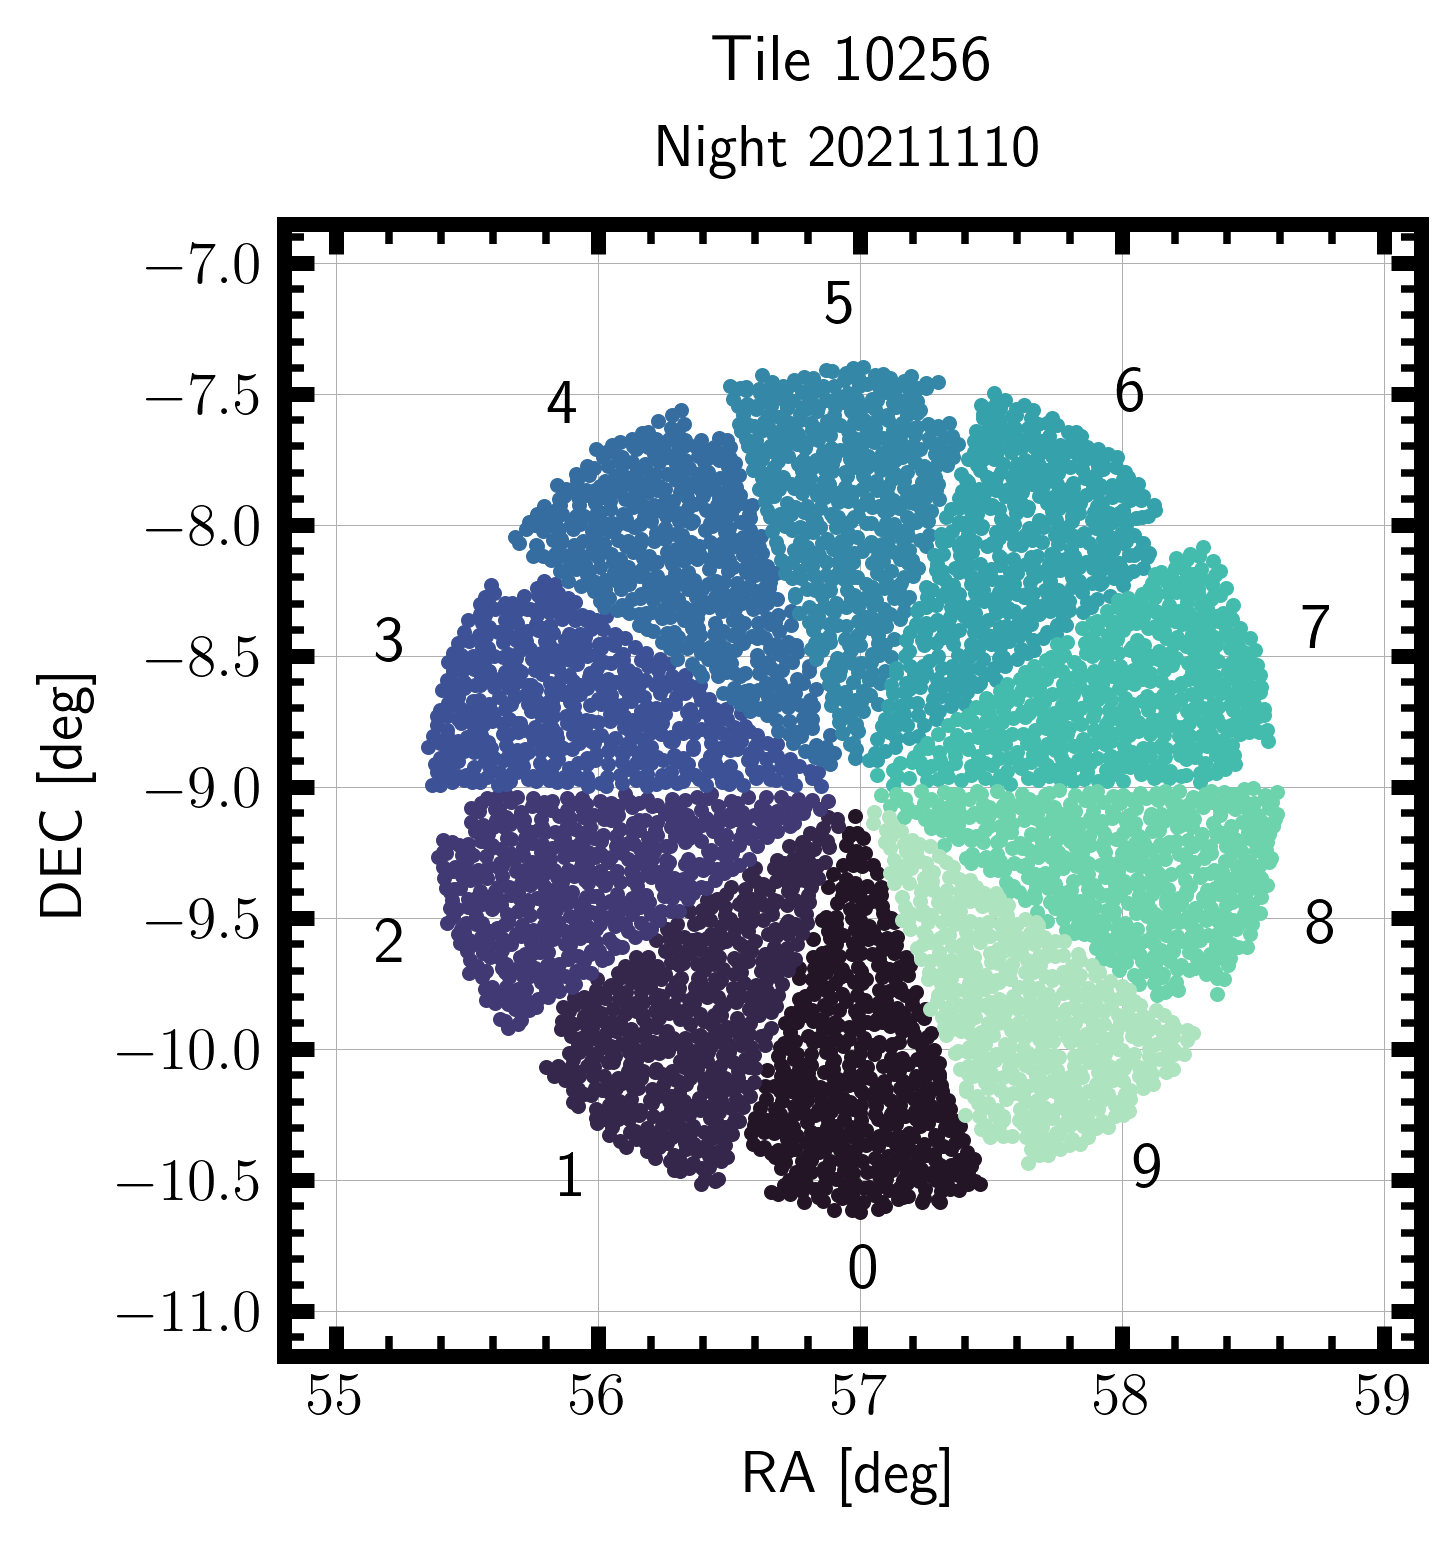

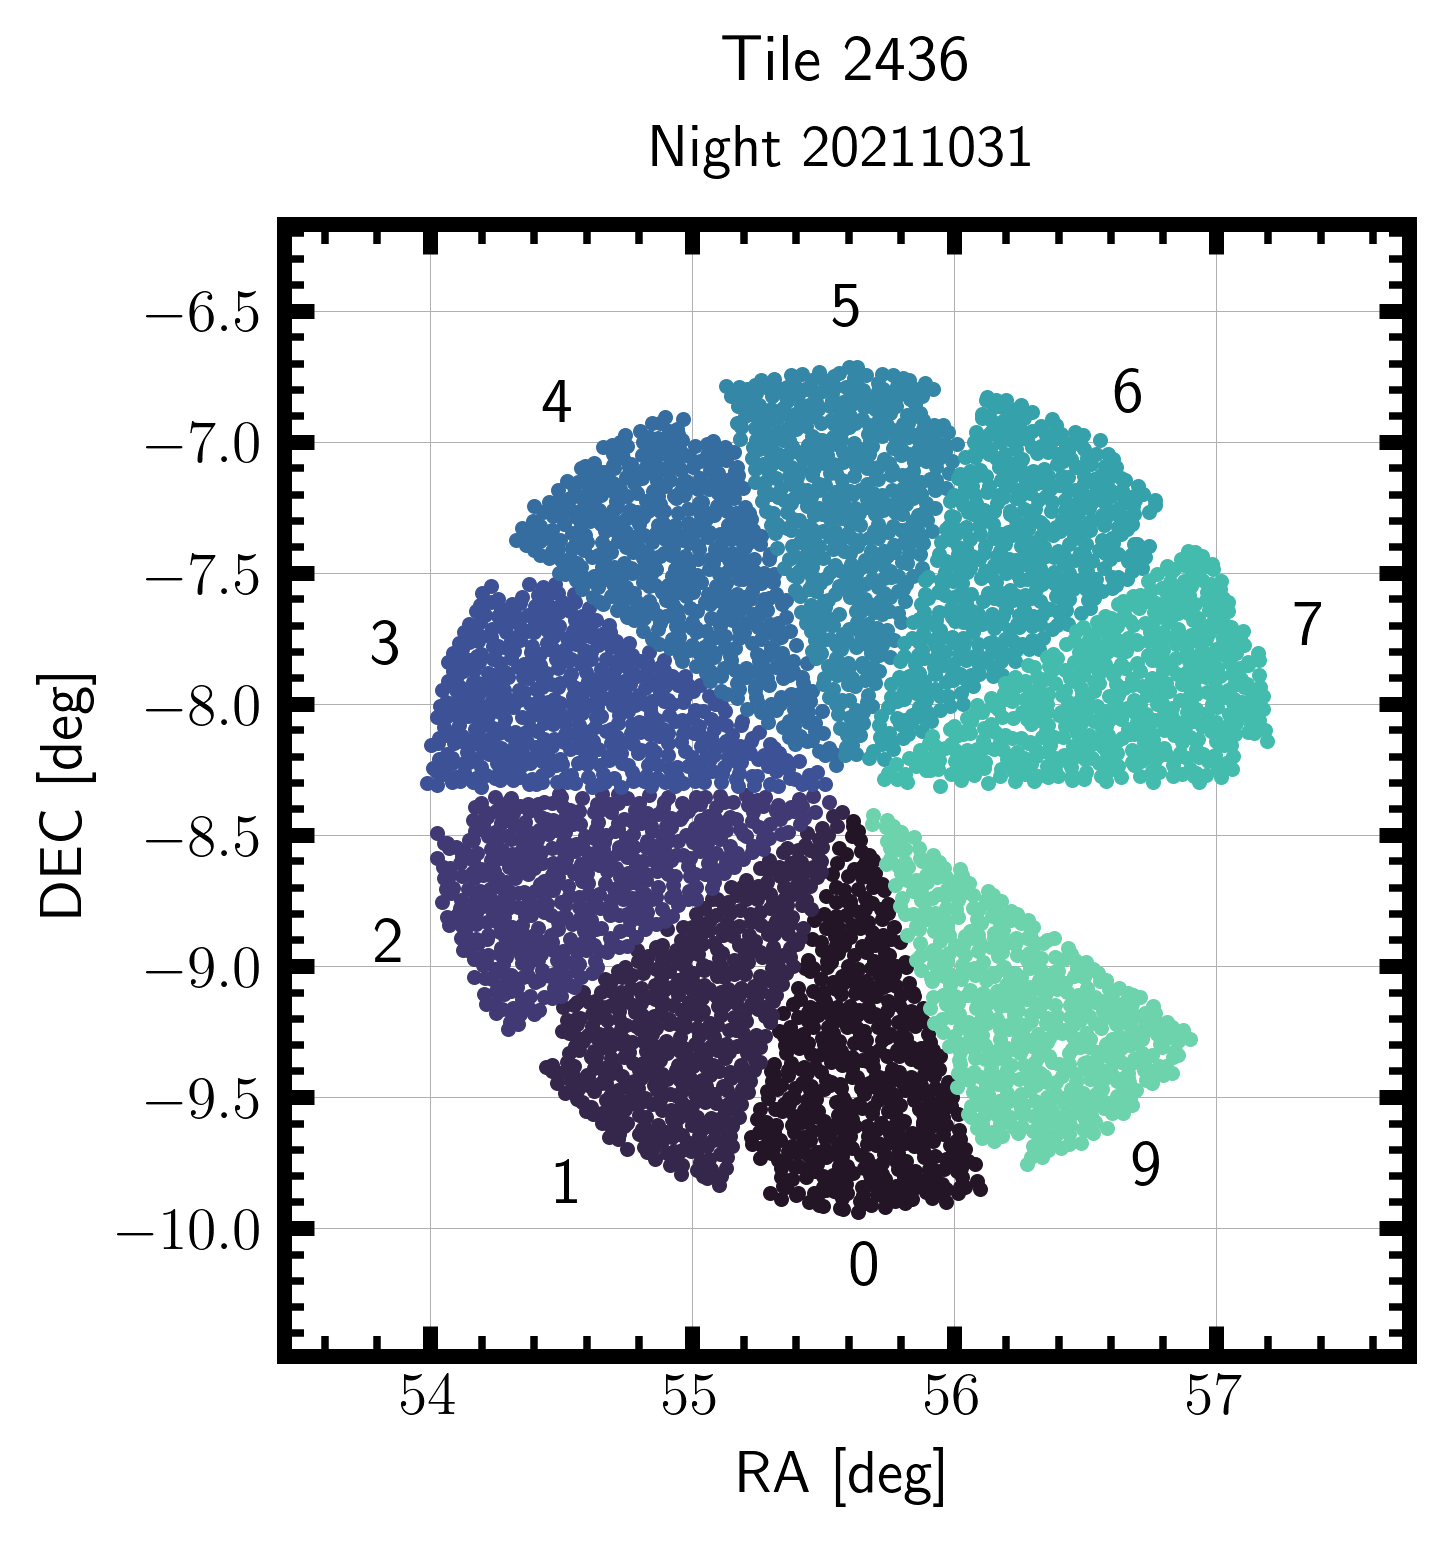

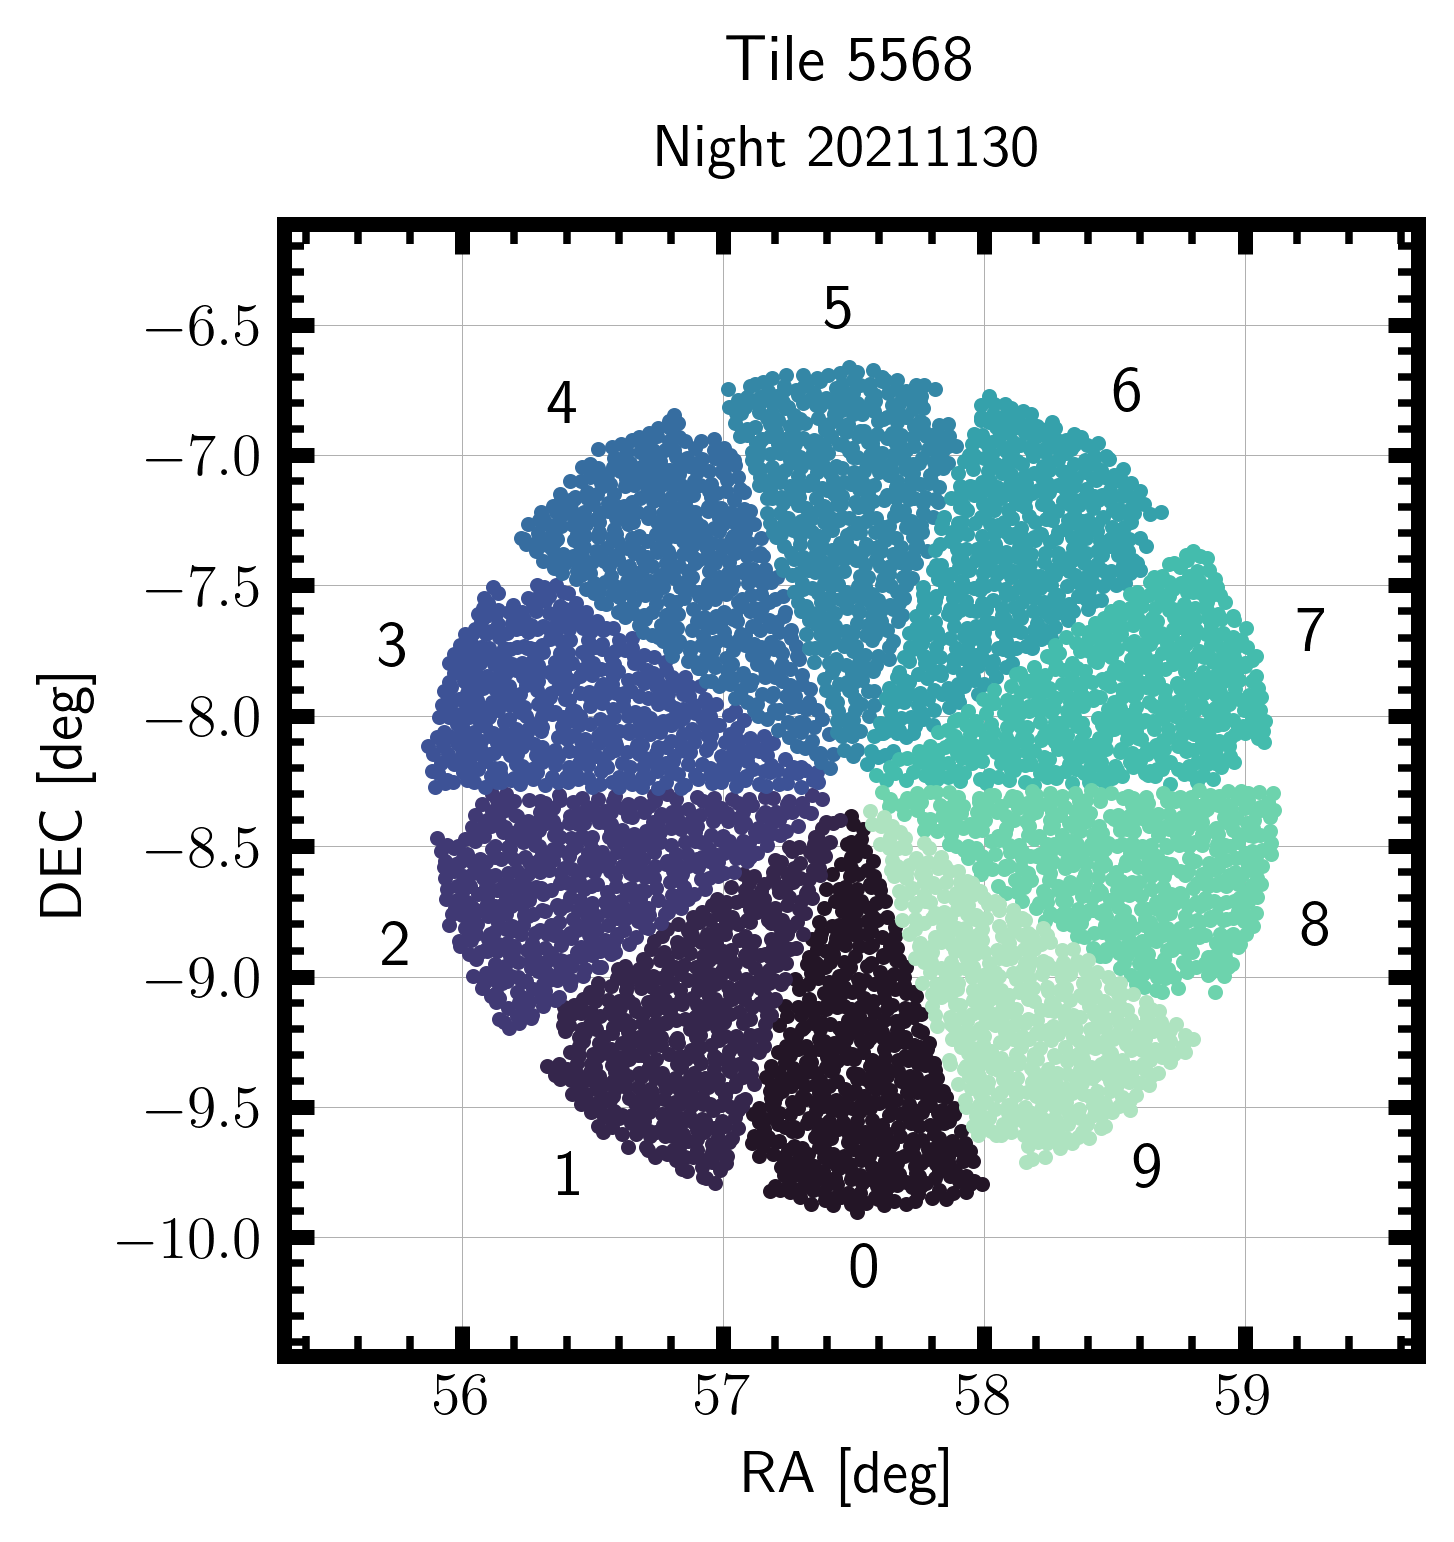

In [7]:
for i, night in enumerate(nights):

    tile = [f for f in os.listdir(f'{path}/{tiles_id[i]}/{night}') if f.startswith('coadd-')]

    fig, ax = plt.subplots()
    for j, petal in enumerate(tile):
        data = fits.open(f'{path}/{tiles_id[i]}/{night}/{petal}')[1].data
        ax.scatter(data['TARGET_RA'], data['TARGET_DEC'], s=4,
                c=[palette[j]], zorder=10)

        mean_ra, mean_dec = data['TARGET_RA'].mean(), data['TARGET_DEC'].mean()
        d = np.sqrt((data['TARGET_RA'] - mean_ra)**2
                                + (data['TARGET_DEC'] - mean_dec)**2)
        edge_ra, edge_dec = data['TARGET_RA'][np.argmax(d)], data['TARGET_DEC'][np.argmax(d)]
        ax.text(mean_ra - 0.8 * (edge_ra - mean_ra), mean_dec - 0.8 * (edge_dec - mean_dec),
                data['PETAL_LOC'][0], fontsize=13, fontweight='bold', color='black', ha='center', va='center')

    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.margins(x=0.17, y=0.17)

    plt.title(f'Tile {data['TILEID'][0]}', y=1.1, fontdict={'fontsize': 13})
    ax.text(0.5, 1.05, f'Night {night}', fontsize=12, ha='center', transform=ax.transAxes)

    plt.grid(linewidth=0.2, zorder=0)
    plt.xlabel('RA [deg]', fontsize=12)
    plt.ylabel('DEC [deg]', fontsize=12)
    plt.tight_layout()
    # plt.savefig(f'./plots/tiles/tile_{data['TILEID'][0]}_{night}.png', dpi=360)
    plt.show()

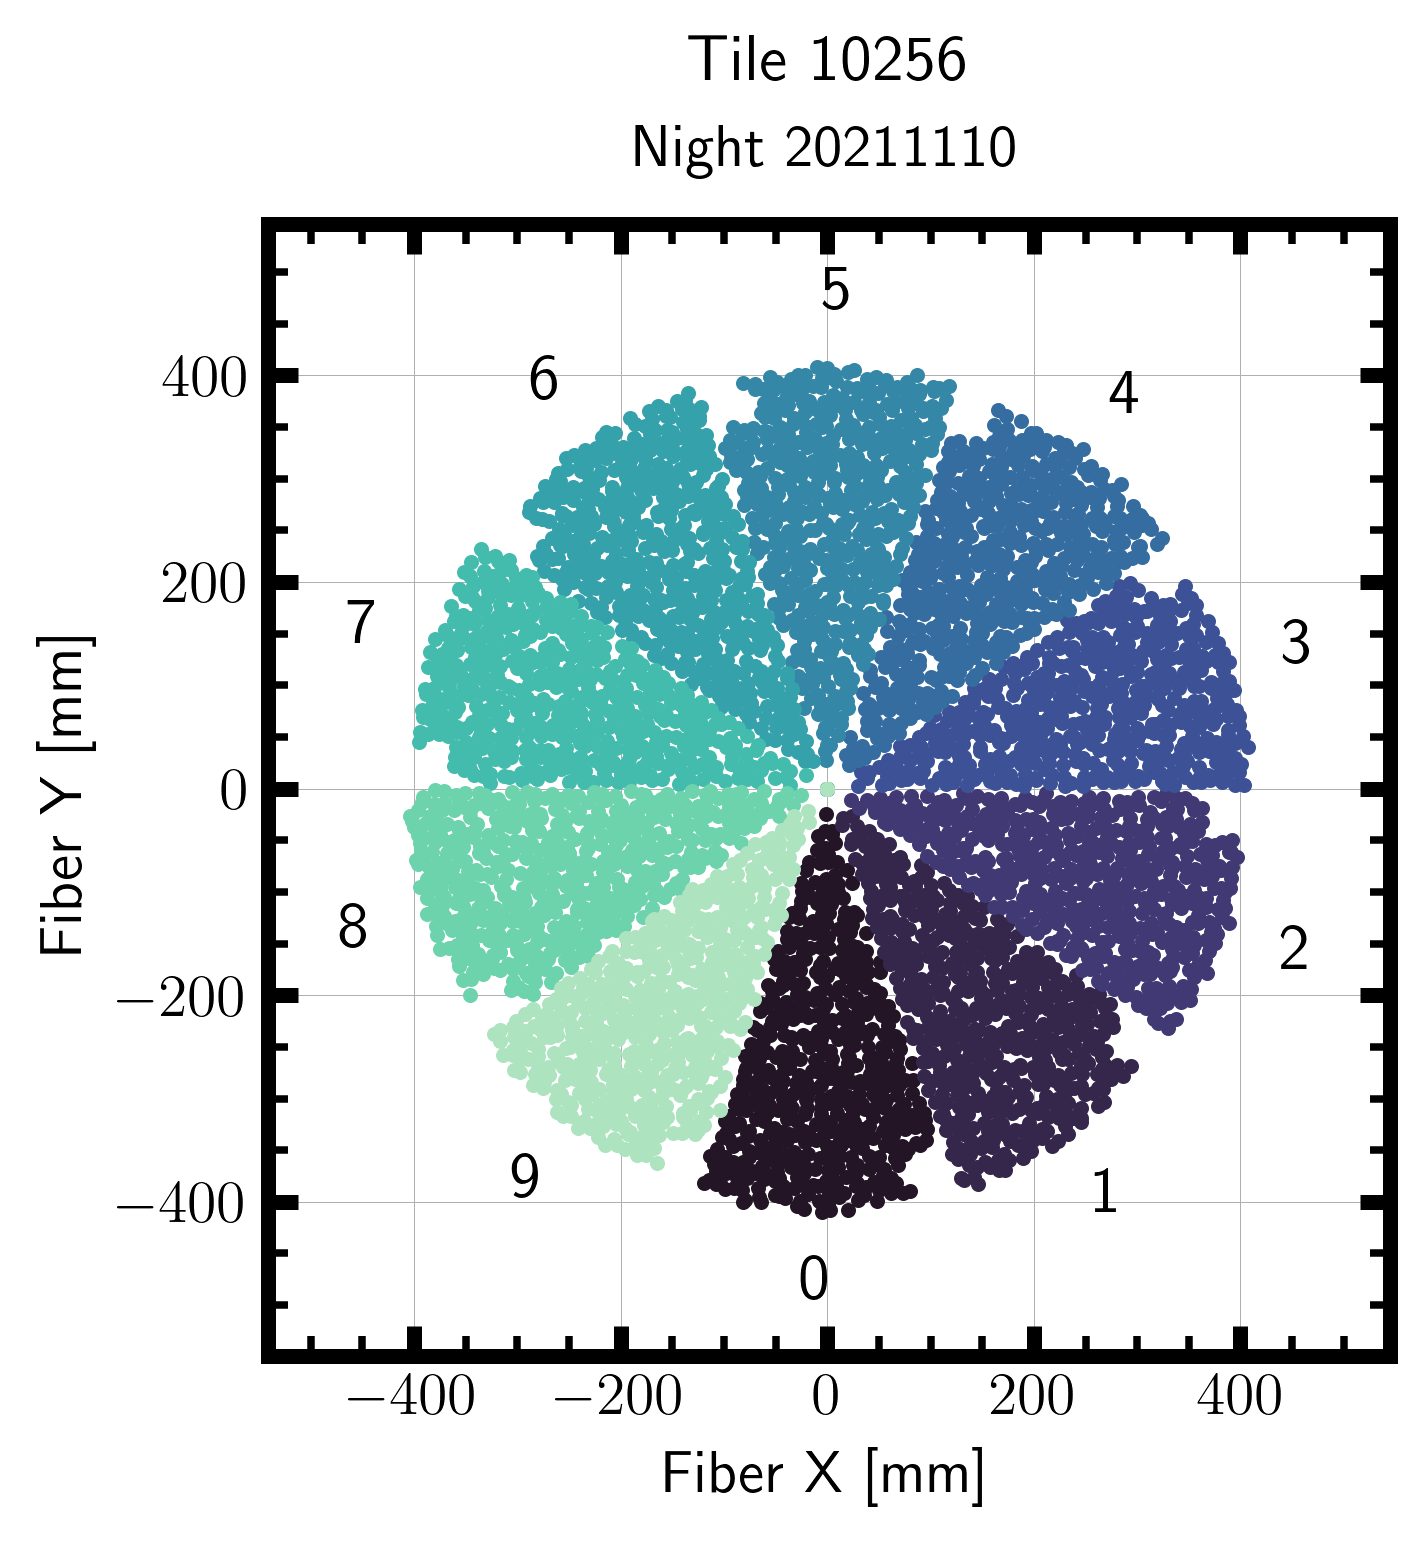

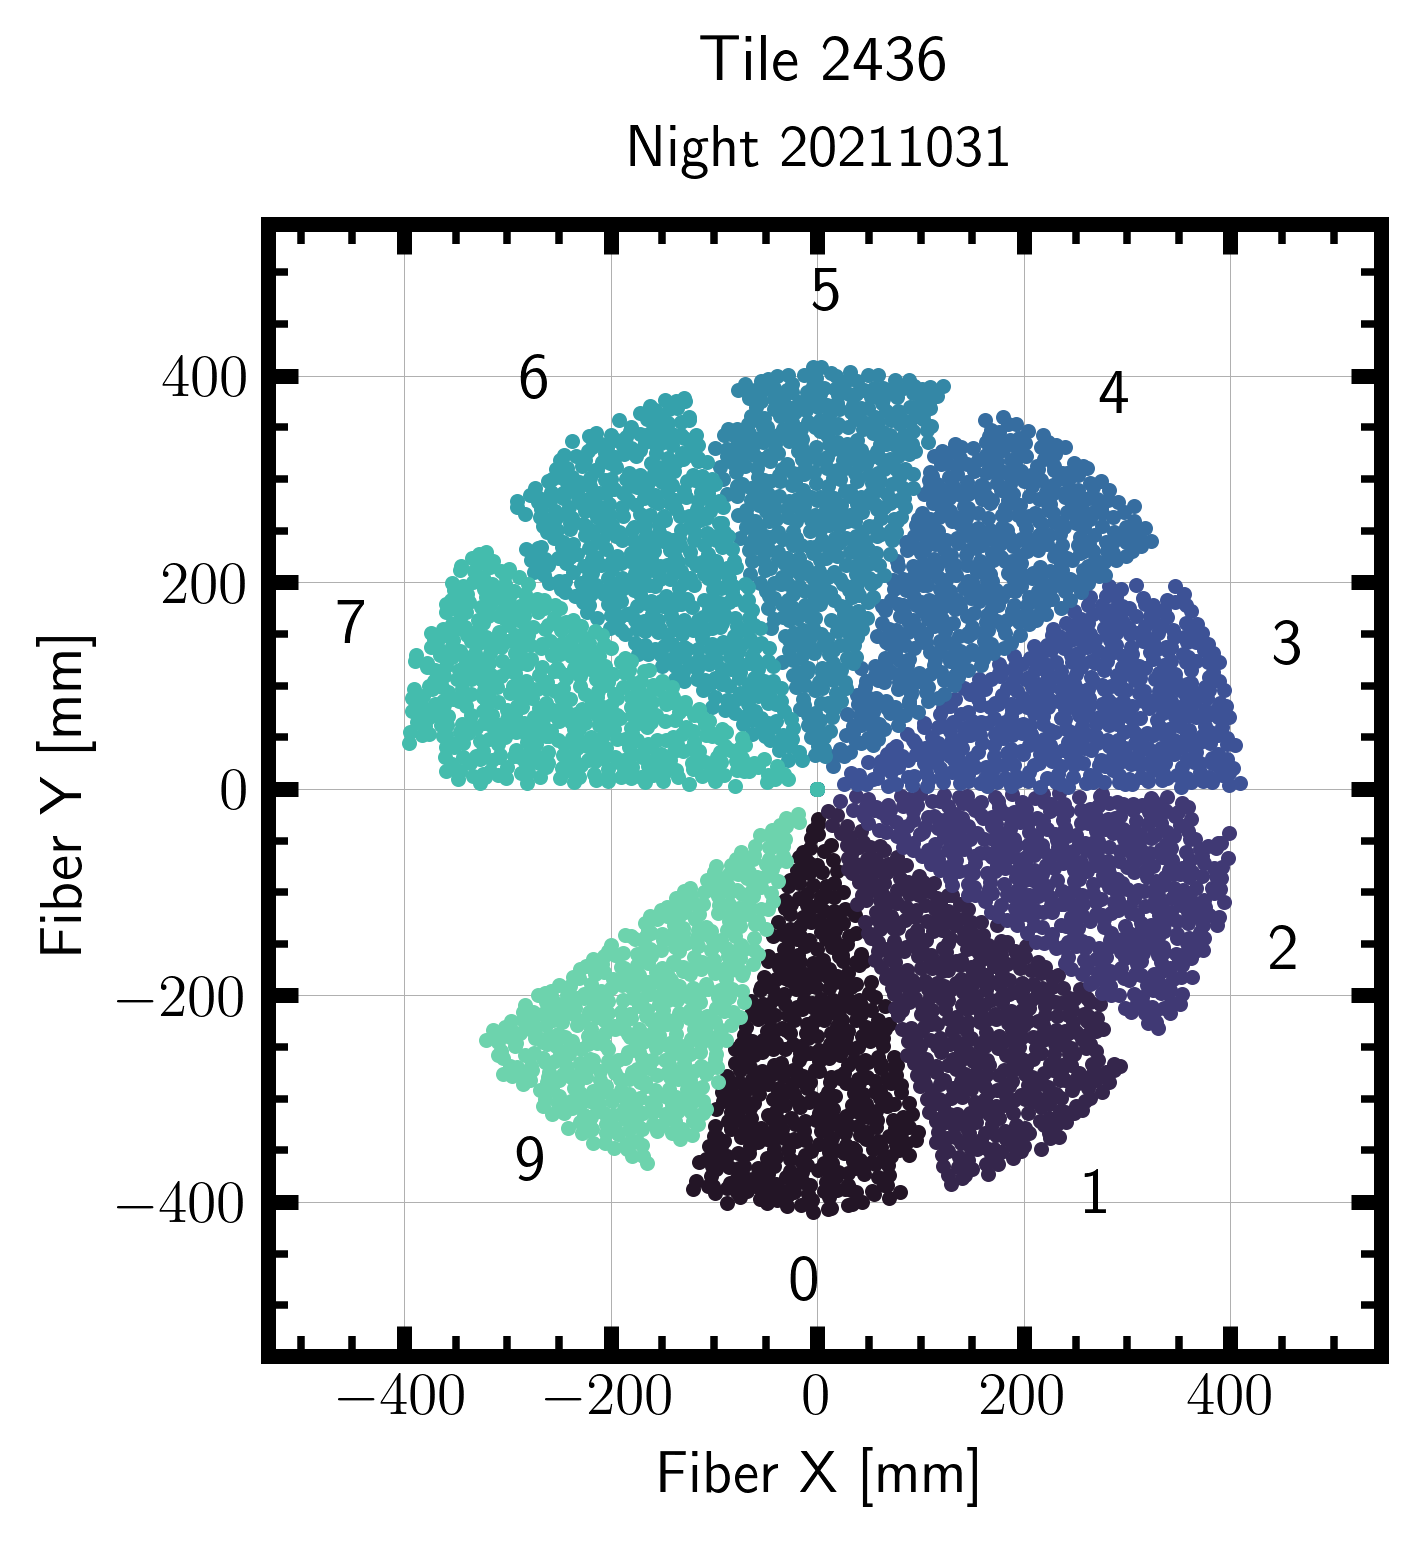

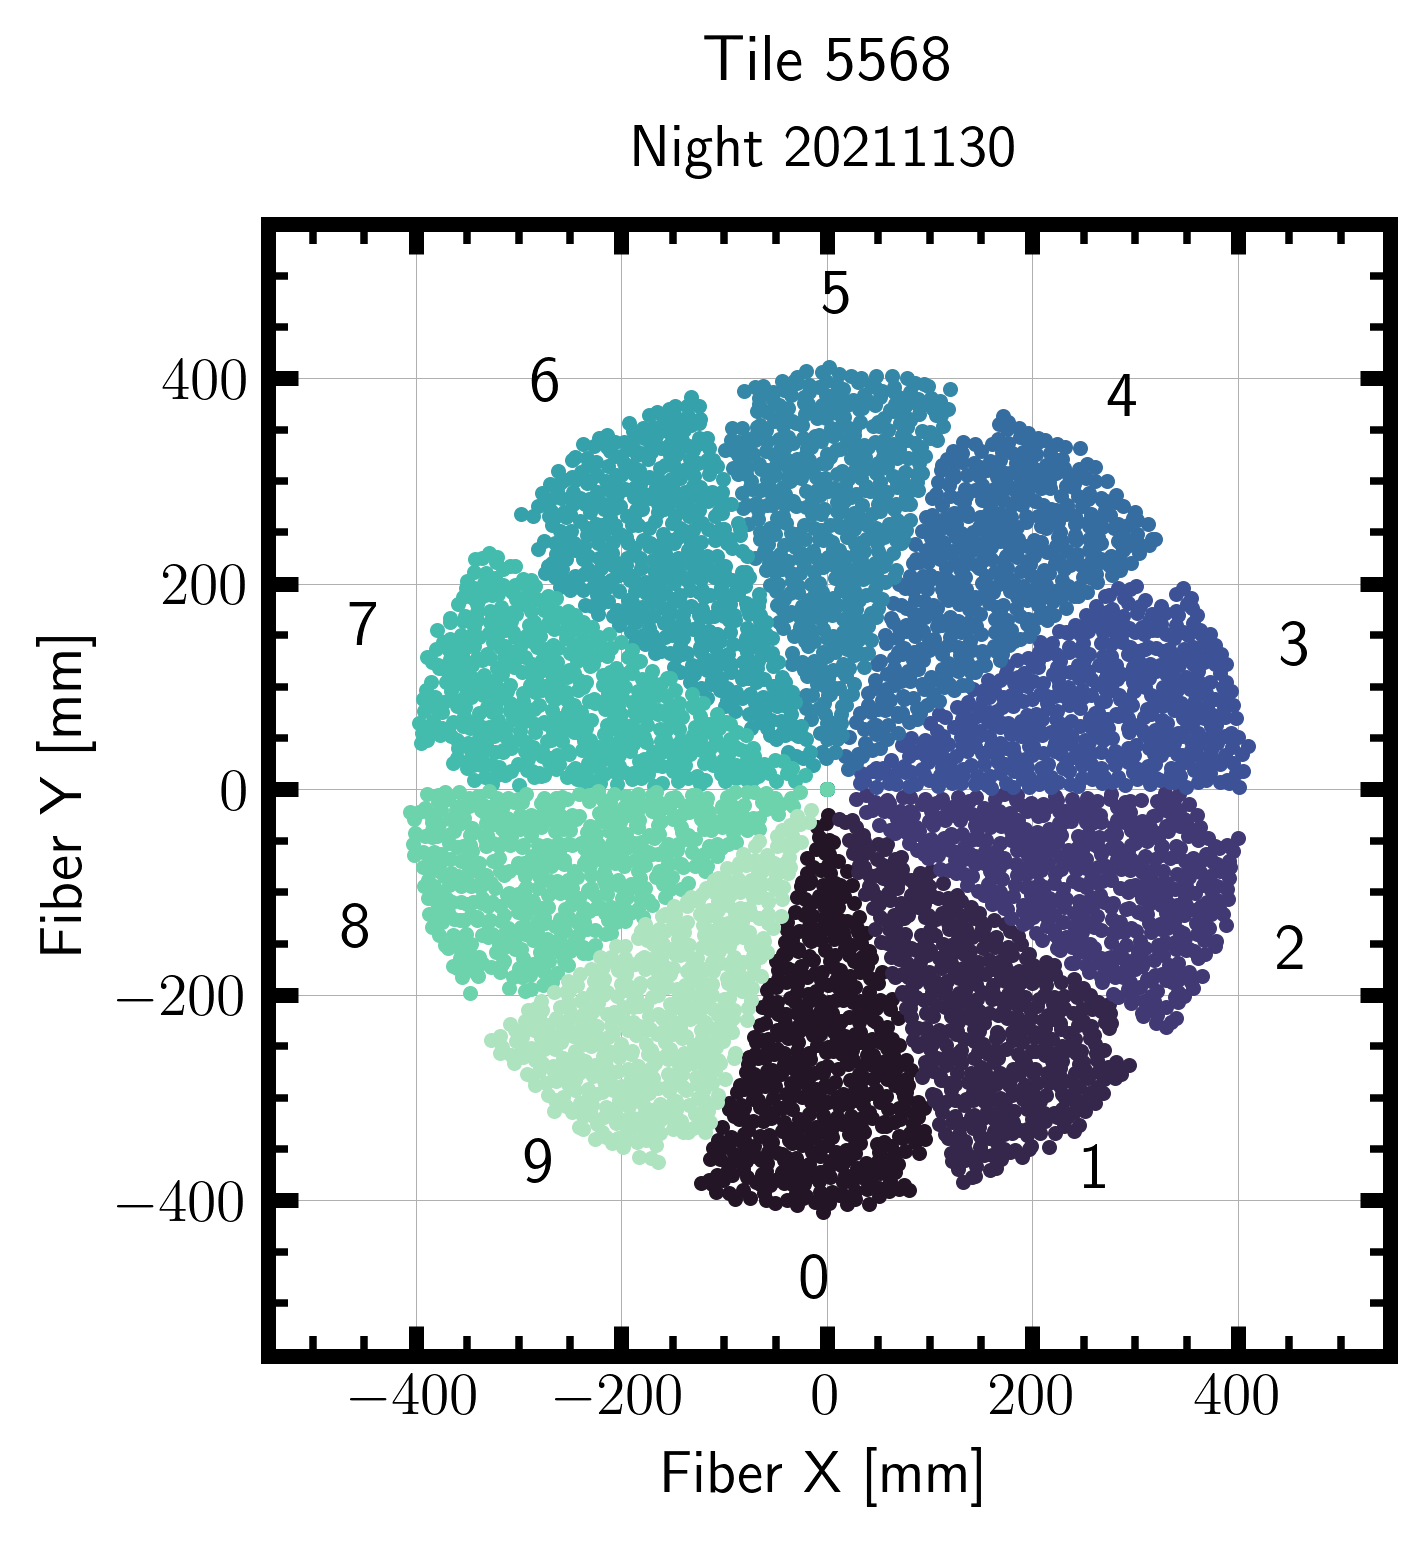

In [119]:
for i, night in enumerate(nights):

    tile = [f for f in os.listdir(f'{path}/{tiles_id[i]}/{night}') if f.startswith('coadd-')]

    fig, ax = plt.subplots()
    for j, petal in enumerate(tile):
        data = fits.open(f'{path}/{tiles_id[i]}/{night}/{petal}')[1].data
        ax.scatter(data['MEAN_FIBER_X'], data['MEAN_FIBER_Y'], s=4,
                c=[palette[j]], zorder=10)

        mean_ra, mean_dec = data['MEAN_FIBER_X'].mean(), data['MEAN_FIBER_Y'].mean()
        d = np.sqrt((data['MEAN_FIBER_X'] - mean_ra)**2
                                + (data['MEAN_FIBER_Y'] - mean_dec)**2)
        edge_ra, edge_dec = data['MEAN_FIBER_X'][np.argmax(d)], data['MEAN_FIBER_Y'][np.argmax(d)]
        ax.text(mean_ra - 0.8 * (edge_ra - mean_ra), mean_dec - 0.8 * (edge_dec - mean_dec),
                data['PETAL_LOC'][0], fontsize=13, fontweight='bold', color='black', ha='center', va='center')

    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.margins(x=0.17, y=0.17)

    plt.title(f'Tile {data['TILEID'][0]}', y=1.1, fontdict={'fontsize': 13, 'fontweight':'bold'})
    ax.text(0.5, 1.05, f'Night {night}', fontsize=12, ha='center', transform=ax.transAxes)

    plt.grid(linewidth=0.2, zorder=0)
    plt.xlabel('Fiber X [mm]', fontsize=12)
    plt.ylabel('Fiber Y [mm]', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'./plots/tiles/tile_fiber_{data['TILEID'][0]}_{night}.png', dpi=360)
    plt.show()

### Spectra

Nights
1. 20211110 - 10256
2. 20211031 - 2436
3. 20211130 - 5568

In [3]:
path = '/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative'

tile = [f for f in os.listdir('/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative/10256/20211110/') if f.startswith('coadd-')]
tile

['coadd-0-10256-thru20211110.fits',
 'coadd-1-10256-thru20211110.fits',
 'coadd-2-10256-thru20211110.fits',
 'coadd-3-10256-thru20211110.fits',
 'coadd-4-10256-thru20211110.fits',
 'coadd-5-10256-thru20211110.fits',
 'coadd-6-10256-thru20211110.fits',
 'coadd-7-10256-thru20211110.fits',
 'coadd-8-10256-thru20211110.fits',
 'coadd-9-10256-thru20211110.fits']

In [4]:
#read combined spectra, data until 20211110
coadd_obj = desispec.io.read_spectra(f'/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative/10256/20211110/coadd-0-10256-thru20211110.fits')

INFO:spectra.py:391:read_spectra: iotime 61.747 sec to read coadd-0-10256-thru20211110.fits at 2025-02-16T13:13:31.197008


In [5]:
#get targets id
coadd_tgts = coadd_obj.target_ids().data

#take ONE row for the first target
row = (coadd_tgts == coadd_tgts[0])
coadd_spec = coadd_obj[row]

In [6]:
coadd_spec.wave

{'b': array([3600. , 3600.8, 3601.6, ..., 5798.4, 5799.2, 5800. ]),
 'r': array([5760. , 5760.8, 5761.6, ..., 7618.4, 7619.2, 7620. ]),
 'z': array([7520. , 7520.8, 7521.6, ..., 9822.4, 9823.2, 9824. ])}

In [7]:
coadd_spec.flux

{'b': array([[ 0.69329101, -0.73104036,  1.7979908 , ...,  0.04578385,
          1.49002481, -1.2514056 ]]),
 'r': array([[0.32543507, 0.46335003, 2.25388002, ..., 0.40032482, 0.45096916,
         1.33182824]]),
 'z': array([[ 0.28963864,  0.18482439,  0.27000475, ..., -0.15495072,
          4.27691126, 48.45481491]])}

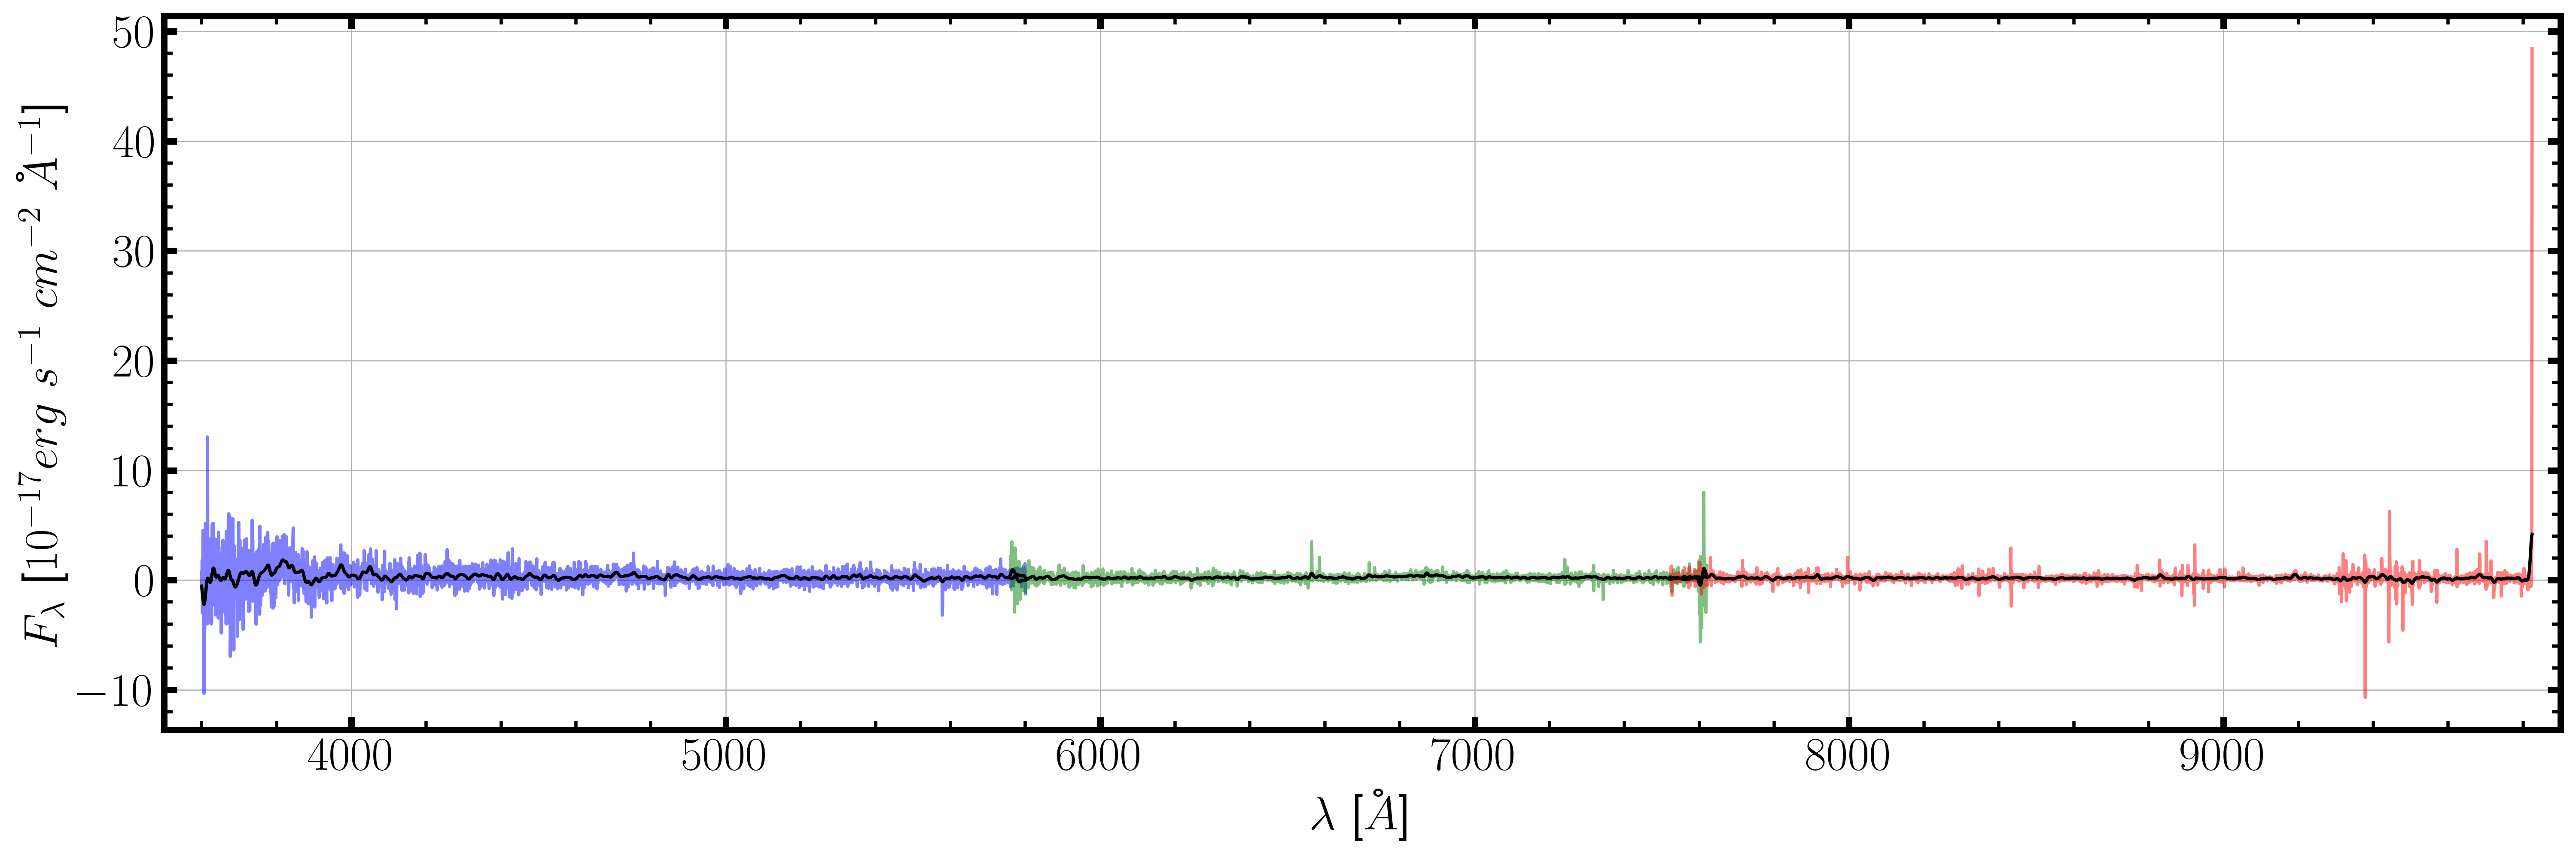

In [8]:
plt.figure(figsize = (20, 6))

#wavelenght vector for each band
plt.plot(coadd_spec.wave['b'], coadd_spec.flux['b'][0], color = 'b', alpha = 0.5)
plt.plot(coadd_spec.wave['r'], coadd_spec.flux['r'][0], color = 'g', alpha = 0.5)
plt.plot(coadd_spec.wave['z'], coadd_spec.flux['z'][0], color = 'r', alpha = 0.5)

#smoothed spectra from convolution
plt.plot(coadd_spec.wave['b'], convolve(coadd_spec.flux['b'][0], Gaussian1DKernel(5)), color = 'k')
plt.plot(coadd_spec.wave['r'], convolve(coadd_spec.flux['r'][0], Gaussian1DKernel(5)), color = 'k')
plt.plot(coadd_spec.wave['z'], convolve(coadd_spec.flux['z'][0], Gaussian1DKernel(5)), color = 'k')
plt.xlim([3500, 9900])
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel(r'$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.grid(linewidth=0.5)
plt.show()